In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import re

from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects
from Models.Caller import *
from BatchMIEvaluation import LoadModelConfigs, LoadParams
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC


In [2]:
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI' in tab and 'Nj1.' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab and 'Nj1.' in tab]

MItableSet = pd.DataFrame() 
for tab in MItableList:
    MItables = pd.read_csv('./EvalResults/Tables/'+tab)
    MItableSet = pd.concat([MItableSet, MItables], axis=0)


BMMItableSet = pd.DataFrame() 
for tab in BMMItableList:
    MItables = pd.read_csv('./Benchmarks/EvalResults/Tables/'+tab)
    BMMItableSet = pd.concat([BMMItableSet, MItables], axis=0)

MItableSet = pd.concat([MItableSet, BMMItableSet])

In [3]:
MItableSet['Model'].unique(), MItableSet['Metrics'].unique()

(array(['FACFC_ART_30_500', 'FACFC_ART_50_500', 'SKZFC_ART_30_500',
        'SKZFC_ART_50_500', 'SKZ_ART_30_500', 'SKZ_ART_50_500',
        'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_800',
        'FACFC_ART_50_800', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800',
        'SKZ_ART_30_800', 'SKZ_ART_50_800', 'TCMIDKZFC_ART_30_800',
        'TCMIDKZFC_ART_50_800', 'FACFC_II_30_500', 'FACFC_II_50_500',
        'SKZFC_II_30_500', 'SKZFC_II_50_500', 'SKZ_II_30_500',
        'SKZ_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500',
        'FACFC_II_30_800', 'FACFC_II_50_800', 'SKZFC_II_30_800',
        'SKZFC_II_50_800', 'SKZ_II_30_800', 'SKZ_II_50_800',
        'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'BaseVAE_ART_30',
        'BaseVAE_ART_50', 'FACVAE_ART_30', 'FACVAE_ART_50',
        'ConVAE_ART_30', 'ConVAE_ART_50', 'TCVAE_ART_30', 'TCVAE_ART_50',
        'BaseVAE_II_30', 'BaseVAE_II_50', 'FACVAE_II_30', 'FACVAE_II_50',
        'ConVAE_II_30', 'ConVAE_II_50', 'TCVAE

In [9]:
model

'TCVAE_II_50'

### Comparison with models without conditinoal input

In [25]:
ARTTabList = ['SKZFC_ART_30_500','SKZFC_ART_30_800', 'BaseVAE_ART_30', 'ConVAE_ART_30', 'TCVAE_ART_30', 'FACVAE_ART_30',
               'SKZFC_ART_50_500','SKZFC_ART_50_800', 'BaseVAE_ART_50', 'ConVAE_ART_50', 'TCVAE_ART_50', 'FACVAE_ART_50']

IITabList = ['SKZFC_II_30_500','SKZFC_II_30_800', 'BaseVAE_II_30', 'ConVAE_II_30', 'TCVAE_II_30', 'FACVAE_II_30',
               'SKZFC_II_50_500','SKZFC_II_50_800', 'BaseVAE_II_50', 'ConVAE_II_50', 'TCVAE_II_50', 'FACVAE_II_50']

AnalMetricList = ['(1) I(V;Z)', '(2) $I(V; \\acute{Z} \\mid Z)$']


ModelRename = {}
for model in MItableSet['Model'].unique():
    if bool(re.search('_\d{3}', model)):
        ModelRename[model] = model[:-6] + model[-6:-4] +'D-Z&' +  model[-3:-2] + 's'

    else:
        ModelRename[model] =  model[:-2] + model[-2:]+'D-Z'

    if 'Base' in model:
        ModelRename[model] = 'B-' + model[4:]
        

### Plot

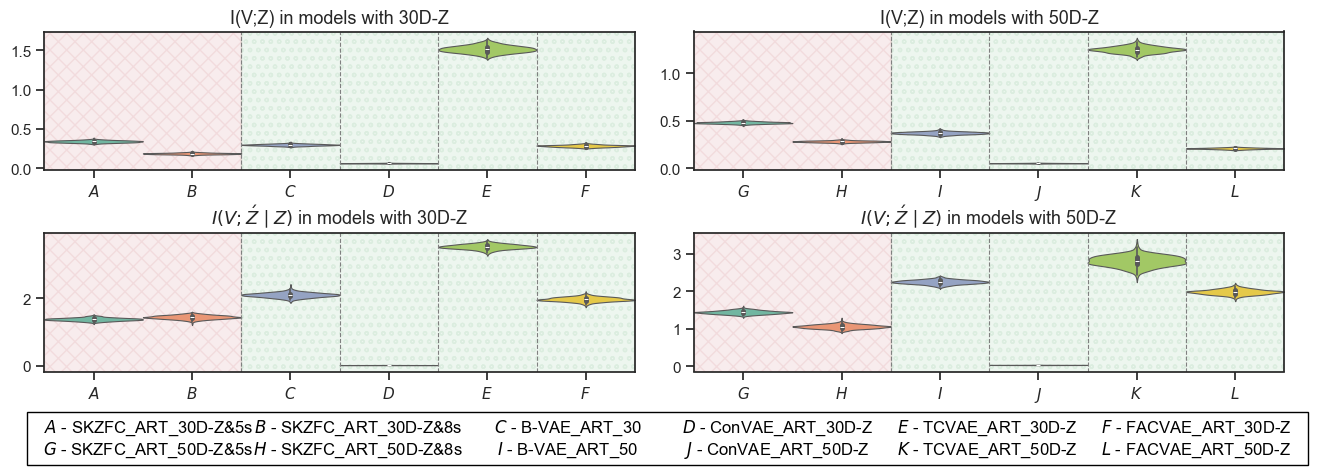

In [26]:
# Set the table list
AnalTabList = ARTTabList #IITabList, ARTTabList

if 'ART' in AnalTabList[0]:
    NZList = ['ART_30', 'ART_50']
else:
    NZList = ['II_30', 'II_50']
   
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList)) & (MItableSet['Metrics'].isin(AnalMetricList))].reset_index(drop=True)
AnalMItableSet['MetricNew'] = AnalMItableSet['Metrics'].str[4:]

sns.set(style="ticks")

metrics_categories = AnalMItableSet['MetricNew'].unique()


# Renaming models
AnalMItableSet['Model'] = AnalMItableSet['Model'].map(ModelRename)
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]


alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
DictModelLabel = {model: f'${alphabet[i]}$' for i, model in enumerate(AnalTabList)}

# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableSet = AnalMItableSet.drop(columns=['SortKey'])



global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()

total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

fig, axes = plt.subplots(len(metrics_categories), 2, figsize=(16, 5))  # Increased figure size for annotation space
axes = axes.flatten()

for i, metric in enumerate(metrics_categories):
    SubsetMet = AnalMItableSet[AnalMItableSet['MetricNew'] == metric]
    
    for j, NZ in enumerate(NZList): # ['II_30', 'II_50'] ['ART_30', 'ART_50']
        ax = axes[i*2 + j]
        Subset = SubsetMet[SubsetMet['Model'].str.contains(NZ)]
        
        # Sort models alphabetically based on the labels
        unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
        
        NumModels = len(unique_models_subset)

        for line_pos in [1.5, 2.5, 3.5, 4.5]:
            ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.8)
        ax.axvspan(-0.5, 1.5, facecolor='r', alpha=0.1, hatch='xx', edgecolor='r')
        ax.axvspan(1.5, 9.5, facecolor='g', alpha=0.1, hatch='oo', edgecolor='g')
        
        sns.violinplot(x='Model', y='Values', hue='Model', data=Subset, inner='box',
                       ax=ax, palette=fixed_palette[:NumModels], legend=False,
                       linewidth=.8, width=1., order=unique_models_subset)
        ax.set_title(metric + ' in models with ' + NZ[-2:] + 'D-Z', fontsize=13)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(range(NumModels))
        ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.1, hspace=0.45)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

# Determine positions for two rows and six columns
positions = []
for i in range(2):  # Two rows
    for j in range(6):  # Six columns
        x = 0.19 + j * 0.131  # Adjust horizontal spacing and starting position as needed
        y = 0.08 - i * 0.045  # Adjust vertical spacing and starting position as needed
        positions.append((x, y))

# Create text objects for each annotation
textobjs = [fig.text(x, y, f"{label} - {model}", ha='center', color='black',  fontsize=12,transform=fig.transFigure)
            for (x, y), (model, label) in zip(positions, sorted_labels)]

fig.canvas.draw()

# Calculate the bounding box for all text objects
xmin = min([t.get_window_extent().xmin for t in textobjs])
xmax = max([t.get_window_extent().xmax for t in textobjs])
ymin = min([t.get_window_extent().ymin for t in textobjs])
ymax = max([t.get_window_extent().ymax for t in textobjs])

# Convert coordinates to figure space
xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

# Add padding
padding = 0.01
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

# Create and add the rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='black', facecolor='none', transform=fig.transFigure)
fig.patches.extend([rect])


if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II.png', bbox_inches='tight')

plt.show()



### Tabulating

In [27]:
AnalMItableEval =  AnalMItableSet[['Model','MetricNew', 'Values']].groupby(['Model','MetricNew']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval

,Model,MetricNew,Values
0,SKZFC_ART_30D-Z&5s,I(V;Z),0.340955
1,SKZFC_ART_30D-Z&5s,$I(V; \acute{Z} \mid Z)$,1.382244
2,SKZFC_ART_30D-Z&8s,I(V;Z),0.187126
3,SKZFC_ART_30D-Z&8s,$I(V; \acute{Z} \mid Z)$,1.445773
4,B-VAE_ART_30,$I(V; \acute{Z} \mid Z)$,2.099589
5,B-VAE_ART_30,I(V;Z),0.298393
6,ConVAE_ART_30D-Z,$I(V; \acute{Z} \mid Z)$,0.028394
7,ConVAE_ART_30D-Z,I(V;Z),0.064078
8,TCVAE_ART_30D-Z,$I(V; \acute{Z} \mid Z)$,3.523789
9,TCVAE_ART_30D-Z,I(V;Z),1.515577


### Comparison with ablation models 

In [5]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800']              

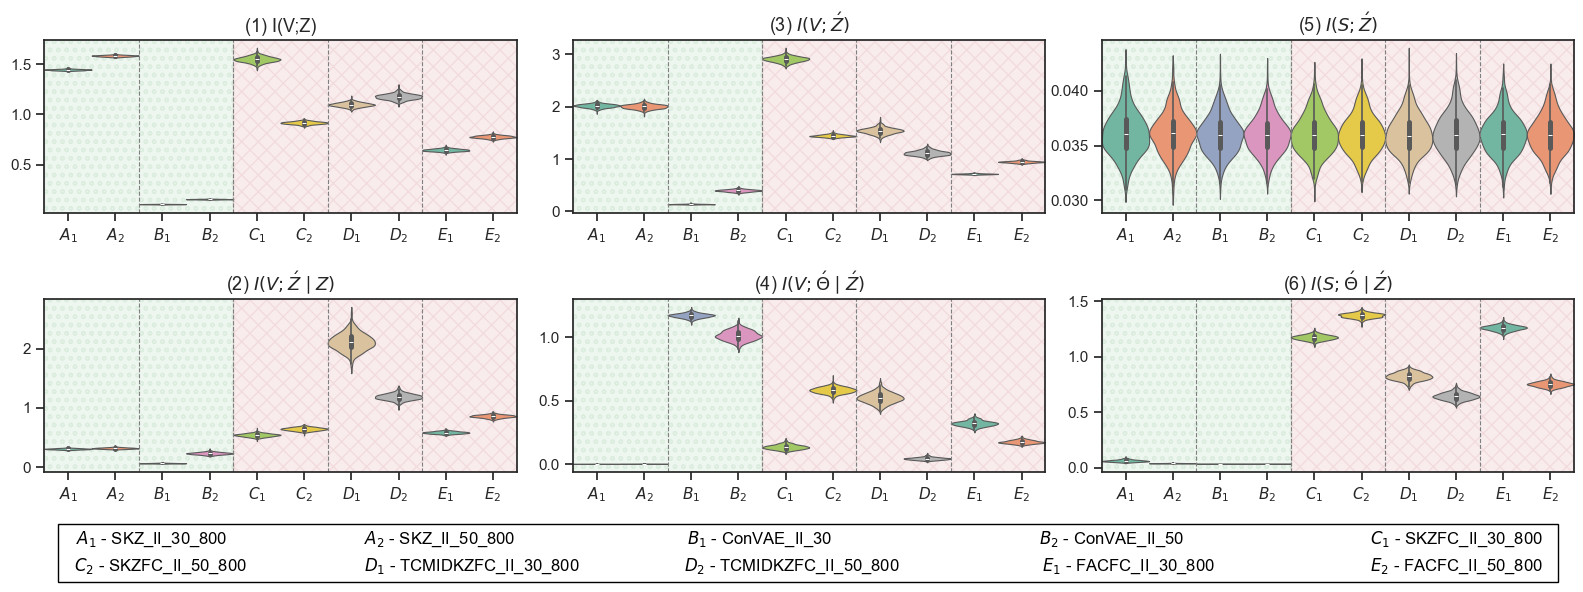

In [29]:
AnalTabList = TabList_II_800  # TabList_ART_500   TabList_ART_800   TabList_II_500   TabList_II_800
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)

# Set the plot style to 'ticks' for a plain background
sns.set(style="ticks")

# Retrieve unique values from the 'Metrics' column
metrics_categories = MItableSet['Metrics'].unique()
ModelLabels = [r'$A_{1}$', r'$A_{2}$', r'$B_{1}$', r'$B_{2}$', r'$C_{1}$', r'$C_{2}$', r'$D_{1}$', r'$D_{2}$', r'$E_{1}$', r'$E_{2}$']
DictModelLabel = {model: f"{ModelLabels[i]}" for i, model in enumerate(AnalTabList)}


# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableSet = AnalMItableSet.drop(columns=['SortKey'])


# Find the global minimum and maximum of the 'Values' column from the entire dataset
global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()

# Create a 3x2 subplot structure
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten(order='F')

# Generate violin plots for each 'Metrics'
for ax, metric in zip(axes, metrics_categories):
    subset = AnalMItableSet[AnalMItableSet['Metrics'] == metric]
    
    # Assign different colors for each Metrics category
    unique_models = subset['Model'].nunique()
    palette = sns.color_palette("Set2", unique_models)

    # Add vertical dashed lines at specified positions based on the length of ModelLabels
    for line_pos in [1.5, 3.5, 5.5, 7.5]:
        ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.8)
    ax.axvspan(-0.5, 3.5, facecolor='g', alpha=0.1, hatch='oo', edgecolor='g')
    ax.axvspan(3.5, 9.5, facecolor='r', alpha=0.1, hatch='xx', edgecolor='r')
        
    sns.violinplot(x='Model', y='Values', hue='Model', data=subset, inner='box',
                   ax=ax, palette=palette, legend=False,
                   linewidth=.8, width=1.)
    
    ax.set_title(metric, fontsize=13)  # Set title for each subplot
    ax.set_xlabel('')  # Clear the x-axis label
    ax.set_ylabel('')  # Clear the y-axis label
    ax.set_xticks(range(unique_models))  # Set the position of ticks on the x-axis
    ax.set_xticklabels(ModelLabels[:unique_models])  # Set the labels for the x-axis ticks



plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.5)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

# Determine positions for annotations
num_labels = len(ModelLabels)
# Determine positions for two rows and six columns

positions = []
'''
for i in range(1):  # 1 rows
    for j in range(8):  # eight columns for i,
        x = 0.1 + j * 0.2   # Adjust horizontal spacing and starting position as needed
        y = 0.08 - i * 0.05  # Adjust vertical spacing and starting position as needed
        positions.append((x, y))
'''
positions.append((0.10, 0.08)) # SKZ_ART_30_500'
positions.append((0.28, 0.08)) # SKZ_ART_50_500
positions.append((0.48, 0.08)) # ConVAE_ART_30
positions.append((0.7, 0.08)) # ConVAE_ART_50
positions.append((0.915, 0.08)) # SKZFC_ART_30_500

positions.append((0.105, 0.035)) # SKZFC_ART_50_500
positions.append((0.30, 0.035)) # TCMIDKZFC_ART_30_500
positions.append((0.5, 0.035)) # TCMIDKZFC_ART_50_500
positions.append((0.71, 0.035)) # FACFC_ART_30_500
positions.append((0.915, 0.035)) # FACFC_ART_50_500


# Create text objects for each annotation
textobjs = [fig.text(x, y, f"{label} - {model}", ha='center', color='black',  fontsize=12,transform=fig.transFigure)
            for (x, y), (model, label) in zip(positions, sorted_labels)]


# Draw the figure to update text positions
fig.canvas.draw()

# Calculate the bounding box for all text objects
xmin = min([t.get_window_extent().xmin for t in textobjs])
xmax = max([t.get_window_extent().xmax for t in textobjs])
ymin = min([t.get_window_extent().ymin for t in textobjs])
ymax = max([t.get_window_extent().ymax for t in textobjs])

# Convert coordinates to figure space
xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

# Add padding
padding = 0.01
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

# Create and add the rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='black', facecolor='none', transform=fig.transFigure)
fig.patches.extend([rect])


CompLen = AnalMItableSet['Model'][0][-3:]
if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART'+CompLen+'_ABL.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II'+CompLen+'_ABL.png', bbox_inches='tight')

# Display the plot
plt.show()

### Tabulating

In [30]:
AnalMItableEval =  AnalMItableSet.groupby(['Model','Metrics']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval

,Model,Metrics,Values
0,SKZ_II_30_800,(1) I(V;Z),1.442042
1,SKZ_II_30_800,(2) $I(V; \acute{Z} \mid Z)$,0.304264
2,SKZ_II_30_800,(3) $I(V;\acute{Z})$,2.015811
3,SKZ_II_30_800,(4) $I(V;\acute{\Theta} \mid \acute{Z})$,0.000523
4,SKZ_II_30_800,(5) $I(S;\acute{Z})$,0.036086
5,SKZ_II_30_800,(6) $I(S;\acute{\Theta} \mid \acute{Z})$,0.063464
6,SKZ_II_50_800,(6) $I(S;\acute{\Theta} \mid \acute{Z})$,0.040935
7,SKZ_II_50_800,(1) I(V;Z),1.579967
8,SKZ_II_50_800,(2) $I(V; \acute{Z} \mid Z)$,0.316104
9,SKZ_II_50_800,(3) $I(V;\acute{Z})$,2.001357


### Plot result difference according to Nj

In [6]:
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI' in tab ]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab ]

def ExtractNj(Filename):
    Match = re.search(r'Nj(\d+)\.', Filename)
    if Match:
        return int(Match.group(1))
    else:
        return None

ARTMItableSet = pd.DataFrame() 
IIMItableSet = pd.DataFrame() 

for tab in MItableList:
    Nj = ExtractNj(tab)
    MItables = pd.read_csv('./EvalResults/Tables/'+tab)
    MItables['Nj'] = Nj

    if 'ART' in tab:
        ARTMItableSet = pd.concat([ARTMItableSet, MItables], axis=0)
    elif 'II' in tab:
        IIMItableSet = pd.concat([IIMItableSet, MItables], axis=0)

SZKFC_II_MIs = IIMItableSet[IIMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()
SZKFC_ART_MIs = ARTMItableSet[ARTMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()

SZKFC_ART_MIs['ModelNj'] = SZKFC_ART_MIs['Model'].str[6:] + '_Nj'+ SZKFC_ART_MIs['Nj'].astype('str')
SZKFC_ART_MIs['Model'] =  SZKFC_ART_MIs['Model'].str[10:12] +'D-Zj&'  + SZKFC_ART_MIs['Model'].str[13:14] + 's'

#SZKFC_ART_MIs = SZKFC_ART_MIs[['ModelNj','Metrics', 'Values']].copy()

SZKFC_II_MIs['ModelNj'] = SZKFC_II_MIs['Model'].str[6:] + '_Nj'+ SZKFC_II_MIs['Nj'].astype('str')
SZKFC_II_MIs['Model'] =  SZKFC_II_MIs['Model'].str[9:11] +'D-Zj&'  + SZKFC_II_MIs['Model'].str[12:13] + 's'
#SZKFC_II_MIs = SZKFC_II_MIs[['ModelNj','Metrics', 'Values']].copy()

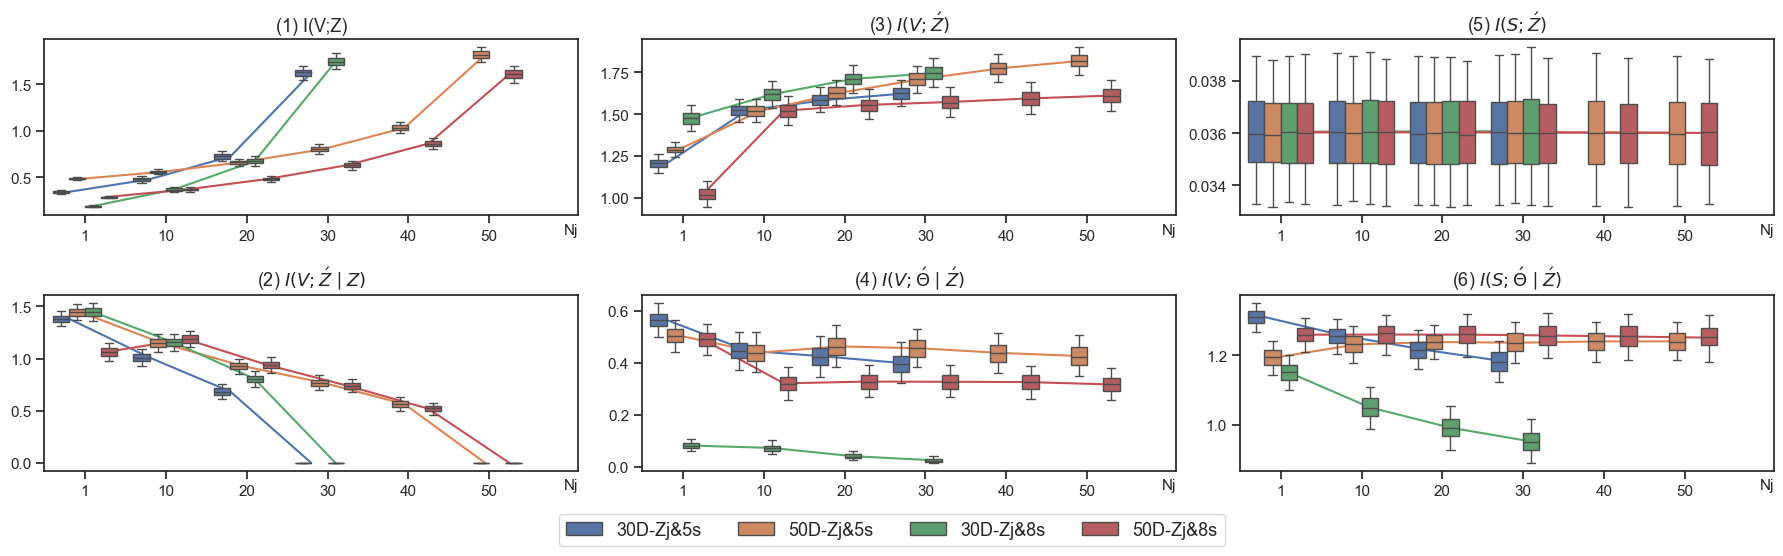

In [7]:

# Example assignment (replace with your actual data)
AnalMItableEval = SZKFC_ART_MIs  # SZKFC_ART_MIs, SZKFC_II_MIs
SaveName = 'ART'

# Calculate global y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Initialize an empty list to collect legend handles
legend_handles = []

# Iterate through unique 'Metrics'
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i % 2, i // 2]   # Determine the subplot position
    metric_data = AnalMItableEval[AnalMItableEval['Metrics'] == metric]
    
    # Get all unique 'Nj' values across all models (ensuring alignment)
    all_nj_values = metric_data['Nj'].unique()
    position_dict = {nj: pos for pos, nj in enumerate(all_nj_values)}

    # Iterate through unique 'Model'
    xmove = -0.2
    for j, model in enumerate(metric_data['Model'].unique()):
        model_data = metric_data[metric_data['Model'] == model]

        # Calculate mean for each 'Nj'
        mean_values = model_data.groupby('Nj')['Values'].mean().reindex(all_nj_values)

        # Line Plot for Central Tendency (Mean), set label to None
        ax.plot([position_dict[nj] + xmove for nj in mean_values.index], mean_values, label=None)
        xmove += 0.15

    # Overlay Box Plot and store legend info
    bplot = sns.boxplot(data=metric_data, x='Nj', y='Values', hue='Model', ax=ax, showfliers=False, whis=[5, 95])
    if i == 0:  # Only need to extract legend info once
        legend_handles = bplot.get_legend_handles_labels()[0]

    # Set the y-axis limits for each subplot to the global min and max
    #ax.set_ylim(global_min, global_max)

    # Set the title and labels for each subplot
    ax.set_title(metric, fontsize=13)
    ax.set_ylabel('')  # Replace with your actual y-label
    
    
    ax.set_xlabel('')  # Remove the default x-label
    # Extend the x-axis limits to create space for the text
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    # Set custom x-axis label at the bottom right
    ax.text(1.0, -0.12, 'Nj', ha='right', va='bottom', fontsize=11, transform=ax.transAxes)
    
    

    # Set x-ticks to the correct position and label
    ax.set_xticks(np.arange(len(all_nj_values)))
    ax.set_xticklabels(all_nj_values)

    # Remove individual subplot legends
    ax.legend().set_visible(False)

plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.45)

# Create a unified legend for the figure using the stored handles
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.06), fontsize=13)

if 'ART' in SaveName:
    plt.savefig('./EvalResults/Figures/BP_ART_Njs.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/BP_II_Njs.png', bbox_inches='tight')
    
# Display the plot
plt.show()


### 3D scatter plots

In [6]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800']    

In [4]:
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

AcctableList = [tab for tab in TableList if 'Acc' in tab and 'Nj1.' in tab]
BMAcctableList = [tab for tab in BMtableList if 'Acc' in tab and 'Nj1.' in tab]

AcctableSet = pd.DataFrame() 
for tab in AcctableList:
    Acctables = pd.read_csv('./EvalResults/Tables/'+tab)
    AcctableSet = pd.concat([AcctableSet, Acctables], axis=0)

BMAcctableSet = pd.DataFrame() 
for tab in BMAcctableList:
    Acctables = pd.read_csv('./Benchmarks/EvalResults/Tables/'+tab)
    BMAcctableSet = pd.concat([BMAcctableSet, Acctables], axis=0)

AcctableSet = pd.concat([AcctableSet, BMAcctableSet])

In [7]:
# Combine the ART 800 and ART 500 tab lists into one for analysis
AnalTabList = TabList_ART_800 + TabList_ART_500 + TabList_II_500 +  TabList_II_800 # TabList_ART_500, TabList_ART_800, TabList_II_500, TabList_II_800

# Define the list of metrics to be analyzed
AnalMetricList= ['(2) $I(V; \\acute{Z} \\mid Z)$', '(6) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']
# Filter the MI table set for models in the Analysis Tab List and reset the index for clean slicing
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Filter the Accuracy table set for models in the Analysis Tab List and reset the index for clean slicing
AnalAcctableSet =  AcctableSet[(AcctableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Calculate the Reverse Kullback-Leibler Divergence (RevKLD) by taking the exponential of the negative mean KLD results
AnalAcctableSet['RevKLD'] = np.exp(-AnalAcctableSet['MeanKldRes'])
AnalAcctableSet['Reconstruction'] = (1-AnalAcctableSet['MAPEnorm']/100)
AnalAcctableSet['NormRevKLD'] = (-AnalAcctableSet['RevKLD'] + AnalAcctableSet['RevKLD'].min()) / (-AnalAcctableSet['RevKLD'].max() + AnalAcctableSet['RevKLD'].min())

# Keep only the 'Model' and 'RevKLD' columns in the Analysis Accuracy table set
AnalAcctableSet = AnalAcctableSet[['Model', 'RevKLD', 'Reconstruction']].copy()

In [8]:
def Normalization(series):
    if np.issubdtype(series.dtype, np.number):  # Check if the series is numeric.
        return (series - series.min()) / (series.max() - series.min())  # Apply min-max normalization.
    return series  # Return the series unchanged if it's not numeric.

def calculate_quantiles_and_indices(df, keyword):
    # Filter the dataframe for rows where the 'Model' column contains the specified keyword
    filtered_data = df[df['Model'].str.contains(keyword)]

    # Calculate quantiles for the filtered data for each metric
    #QRevKLD = filtered_data['RevKLD'].quantile([.0, 1], interpolation="nearest")
    QRecon = filtered_data['Reconstruction'].quantile([.0, 1], interpolation="nearest")
    QDise = filtered_data['Disentanglement'].quantile([.0, 1], interpolation="nearest")
    QCont = filtered_data['Controllability'].quantile([.0, 1], interpolation="nearest")

    # Find the indices corresponding to the quantiles in the original dataframe
    Indices = []
    for qKLD, qDise, qCont in zip(QRecon, QDise, QCont):
        IndKLD = df.loc[df['Reconstruction'] == qKLD].index[0]
        IndDise = df.loc[df['Disentanglement'] == qDise].index[0]
        IndCont = df.loc[df['Controllability'] == qCont].index[0]
        # Append the found indices for each metric to the indices list
        Indices.extend([IndKLD, IndDise, IndCont])
    
    return Indices

# Filter MItableSet for models in the AnalTabList and reset the index for clean slicing.
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Group the data by 'Model' and 'Metrics', calculate the mean, and reset the index.
AnalMItableSet = AnalMItableSet.groupby(['Model', 'Metrics']).mean().reset_index().copy()
# Filter the rows where 'Metrics' are in the list of analytical metrics and reset the index.
AnalMItableSet = AnalMItableSet[AnalMItableSet['Metrics'].isin(AnalMetricList)].reset_index(drop=True)
# Pivot the table to have 'Model' as rows, 'Metrics' as columns, and 'Values' as cell values.
AnalMItableSet = pd.pivot(AnalMItableSet, index='Model', columns='Metrics', values='Values').reset_index().copy()
# Rename the columns to more descriptive names.
AnalMItableSet.columns = ['Model', 'Disentanglement', 'Controllability']
# Apply the normalization function to each column in the table.
NormAnalMItableSet = AnalMItableSet.apply(Normalization)

AnalAccMItable = pd.merge(AnalAcctableSet, AnalMItableSet, on='Model', how='inner').sort_values('Model').reset_index(drop=True)

#AnalAccMItable['Rank_Ctr'] = AnalAccMItable['Controllability'].rank(ascending=False)
#AnalAccMItable['Rank_RevKLD'] = AnalAccMItable['RevKLD'].rank(ascending=False)
#AnalAccMItable['Rank_Disen'] = AnalAccMItable['Disentanglement'].rank(ascending=False)
#AnalAccMItable['SumMetrics'] = AnalAccMItable['Rank_Ctr']  + AnalAccMItable['Rank_RevKLD'] + AnalAccMItable['Rank_Disen']

# Perform the operation for rows containing 'ART' and 'II' in the 'Model' column
ART_indices = calculate_quantiles_and_indices(AnalAccMItable, 'ART')
II_indices = calculate_quantiles_and_indices(AnalAccMItable, 'II')
Indices = np.unique(ART_indices + II_indices)

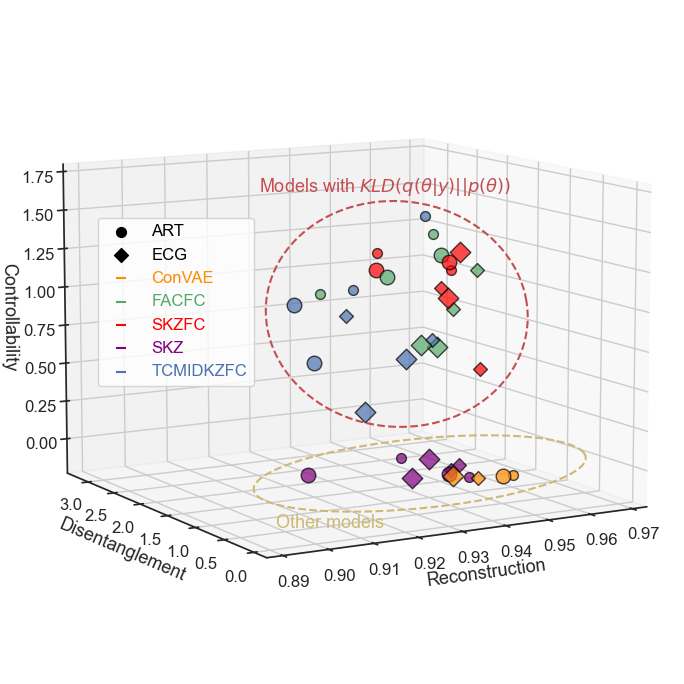

In [9]:
def add_ellipse_to_plot(ax, center, width, height, depth, color='r', linestyle='--'):
    """
    Add an ellipse to a 3D plot.

    Parameters:
    - ax: The axis object to draw the ellipse on.
    - center: The (x, y, z) coordinates of the ellipse's center.
    - width: The width of the ellipse (in the x-direction).
    - height: The height of the ellipse (in the y-direction).
    - depth: The depth of the ellipse (in the z-direction).
    - color: The color of the ellipse line.
    - linestyle: The style of the ellipse line.
    """
    # Create an array of angles from 0 to 2*pi
    angles = np.linspace(0, 2 * np.pi, 100)

    # Calculate the ellipse points in 3D space
    x = center[0] + width * np.cos(angles)
    y = center[1] + height * np.sin(angles)
    z = center[2] + depth * np.sin(angles)  # Modify this for 3D effect

    # Plot the ellipse
    ax.plot(x, y, z, linestyle, color=color)



# Set the style of seaborn for the plot
sns.set(style="ticks")
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.tick_params(axis='x', labelsize=12) 
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='z', labelsize=12) 

# Create empty lists to hold custom legend information
markers = []
colors = []
labels = []
sizes = []
MarkSig = {}
ColMod = {}
ModCol = {}

# Iterate over the rows of the dataframe to plot each point individually
for i, row in AnalAccMItable.iterrows():
    # Determine the marker style based on the 'Model' value
    if 'II' in row['Model']:
        marker = 'D'  # Use '*' for models containing 'II'
        MarkSig[marker] = 'ECG'
        if 'D' not in markers:
            markers.append('D')
            labels.append('Model contains II')
    elif 'ART' in row['Model']:
        marker = 'o'  # Use 'o' for models containing 'ART'
        MarkSig[marker] = 'ART'
        if 'o' not in markers:
            markers.append('o')
            labels.append('Model contains ART')
    else:
        marker = '.'  # Default marker
        if '.' not in markers:
            markers.append('.')
            labels.append('Other Models')


    # Adjust marker size based on 'Model' value
    if '30' in row['Model']:
        marker_size = 50
    elif '50' in row['Model']:
        marker_size = 110
    # Check if this size is already in the list for legends
    if marker_size not in sizes:
        sizes.append(marker_size)

    
    # Determine the color based on the 'Model' value
    if 'ConVAE' in row['Model'] :
        color = 'darkorange'  # Use gray for models containing 'ConVAE' or 'SKZ'
        ColMod[color] = 'ConVAE'
        ModCol['ConVAE'] = color
        if 'darkorange' not in colors:
            colors.append('darkorange')

    elif 'SKZ_' in row['Model']:
        color = 'purple'  # Use green for other models
        ColMod[color] = 'SKZ'
        ModCol['SKZ'] = color
        if 'purple' not in colors:
            colors.append('purple')
    
    elif 'SKZFC' in row['Model']:
        color = 'red'  # Use green for other models
        ColMod[color] = 'SKZFC'
        ModCol['SKZFC'] = color
        if 'red' not in colors:
            colors.append('red')
    
    elif 'FACFC' in row['Model']:
        color = 'g'  # Use green for other models
        ColMod[color] = 'FACFC'
        ModCol['FACFC'] = color
        if 'g' not in colors:
            colors.append('g')
    
    elif 'TCMIDKZFC' in row['Model']:
        color = 'b'  # Use green for other models
        ColMod[color] = 'TCMIDKZFC'
        ModCol['TCMIDKZFC'] = color
        if 'b' not in colors:
            colors.append('b')

    # Plotting the points on the graph with the determined marker and color
    ax.scatter(row['Reconstruction'], row['Disentanglement'], row['Controllability'],
               c=color, marker=marker, s=marker_size, alpha=0.7,edgecolors='black')  # Coloring based on the specified logic

    '''
    if i in Indices:
        ax.text(row['Reconstruction']-0.05, row['Disentanglement'], row['Controllability'], row['Model'] , size=10, zorder=50)
    '''

    
# Create custom legends
for marker in markers:
    ax.scatter([], [], marker=marker, label=MarkSig[marker], c='black', s=50)
    
for color in colors:
    ax.scatter([], [], marker='_', label=ColMod[color], c=color, s=50)

# Set axis labels
ax.set_xlabel('Reconstruction', fontsize=13)  # Label for the x-axis
ax.set_ylabel('Disentanglement', fontsize=13)  # Label for the y-axis
ax.set_zlabel('Controllability', fontsize=13)  # Label for the z-axis

# Set axis limits
#ax.set_xlim(0, 1.)  # Limit for the x-axis
#ax.set_ylim(0, 3.5)  # Limit for the y-axis
#ax.set_zlim(0, 1.5)  # Limit for the z-axis



# Parameters for the ellipse
ellipse_params1 = {
    'center': [0.93, 0.8, 1.],  # 'Reconstruction', 'Disentanglement', 'Controllability'
    'width': 0.03,  # The width (in the Reconstruction)
    'height': .3,  # The height (in the Disentanglement)
    'depth': 0.67,  # The depth (in the Controllability)
    'color': 'r',  # The color of the ellipse
    'linestyle': '--'  # The line style of the ellipse
}

ellipse_params2 = {
    'center': [0.93, 0.40, 0.05],  # 'Reconstruction', 'Disentanglement', 'Controllability'
    'width': 0.038,  # The width (in the Reconstruction)
    'height': 0.38,  # The height (in the Disentanglement)
    'depth': 0.15,  # The depth (in the Controllability)
    'color': 'y',  # The color of the ellipse
    'linestyle': '--'  # The line style of the ellipse
}


# Add an ellipse to the plot
add_ellipse_to_plot(ax, **ellipse_params1)
add_ellipse_to_plot(ax, **ellipse_params2)

ax.text(0.935, 3.6, 1.5, 'Models with ' + '$KLD(q(\\theta | y) || p(\\theta))$' , size=13, zorder=50, color='r')
ax.text(0.89, -0.1, -0.08, 'Other models' , size=13, zorder=50, color='y')

# Display the legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7), fontsize=12)
# Set the text color for each legend item
ModCol['ART'] = 'black'
ModCol['ECG'] = 'black'
for text in legend.get_texts():
    text.set_color(ModCol[text.get_text()])
    
ax.view_init(elev=10, azim=240) #ax.view_init(elev=30, azim=240)

# Adjust the layout to make room for the legend
plt.tight_layout()

plt.savefig('./EvalResults/Figures/3D_Scatter.png', bbox_inches='tight')

# Display the plot
plt.show()


In [ ]:
'(2) $I(V; \\acute{Z} \\mid Z)$'